In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn

Ethen 2017-07-30 19:24:40 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1


# ROC/AUC

In this document we’re given a human resource dataset. Our goal is to find out the employees that are likely to leave in the future and act upon our findings, i.e. retain them before they choose to leave. This dataset contains 12000 observations and 7 variables, each representing :

- `S` The satisfaction level on a scale of 0 to 1
- `LPE` Last project evaluation by a client on a scale of 0 to 1
- `NP` Represents the number of projects worked on by employee in the last 12 month
- `ANH` Average number of hours worked in the last 12 month for that employee
- `TIC` Amount of time the employee spent in the company, measured in years
- `Newborn` This variable will take the value 1 if the employee had a newborn within the last 12 month and 0 otherwise
- `left` 1 if the employee left the company, 0 if they’re still working here. This is our response variable

In [3]:
filename = 'HR.csv'
data = pd.read_csv(filename)
print('dimensions: ', data.shape)
data.head()

dimensions:  (12000, 7)


,S,LPE,NP,ANH,TIC,Newborn,left
0,0.38,0.53,2,157,3,0,1
1,0.80,0.86,5,262,6,0,1
2,0.11,0.88,7,272,4,0,1
3,0.72,0.87,5,223,5,0,1
4,0.37,0.52,2,159,3,0,1


To train and evaluate the model, we’ll perform a simple train/test split. 80 percent of the dataset will be used to actually train the model, while the rest will be used to evaluate the accuracy of this model, i.e. out of sample error. Note that the best practice is to split it in three ways train/validation/test split.

In [4]:
label_col = 'left'
label = data[label_col].values
data = data.drop(label_col, axis = 1)
print('labels distribution:', np.bincount(label) / label.size)

test_size = 0.2
random_state = 1234
data_train, data_test, y_train, y_test = train_test_split(
    data, label, test_size = test_size, random_state = random_state, stratify = label)

labels distribution: [ 0.83333333  0.16666667]


This probability table tells you that around 16 percent of the employees who became a staff member of yours have left! If those employees are all the ones that are performing well in the company, then this is probabliy not a good sign. We'll leave out the exploratory analysis part to you ...

## Sklearn Transformer

We then convert perform some generic data preprocessing including standardizing the numeric columns and one-hot-encode the categorical columns (the "Newborn" variable is treated as a categorical variable) and convert everything into a numpy array that sklearn expects. This generic preprocessing step is written as a custom sklearn Transformer. You don't have to follow this structure if you prefer your way of doing it.

To roll out our own Transformer a adheres to the sklearn API, we need to 

- Ensure that all arguments to the `__init__` method should be explicit: i.e. `*args` or `**kwargs` should be avoided, as they will not be correctly handled within cross-validation routines
- Subclass/Inherit [`BaseEstimator`](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) to get some free stuff. It will give us class representations that are more informative when printing the class object. And provides us a `get_params` and `set_params` functions. These functionalities are used in sklearn's methods such as GridSearch and RandomSearch.
- Subclass/Inherit an appropriate class for your task (one of ClassifierMixin, RegressorMixin, ClusterMixin, TransformerMixin). In our case, we will be implementing a Transformer, thus we'll be subclassing [`TransformerMixin`](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html). For transformer, we need to implement a `.fit` method which fits some stuff on the training data and a `.transform` method that can perform transformation on both the training and test data. Note that we don't need to subclass [`TransformerMixin`](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) this to work, but it does give the end-user the idea that this is a Transformer and we get the `.fit_transform` method that does the fitting and transformer on the training data in one shot for free
- In the fit implementation, you'll notice results that were learned during the `.fit` method is stored with a trailing underscore (e.g., self.colnames_). This is a convention used in sklearn so that we can quickly scan the members of an estimator and distinguish which members are fitting during training time

If you would like to read more on this topic. The following two link might be of interest to you.

- [Blog: Creating your own estimator in scikit-learn](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/)
- [scikit-learn Documentation: Rolling your own estimator](http://scikit-learn.org/dev/developers/contributing.html#rolling-your-own-estimator)

In [5]:
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler


class Preprocess(BaseEstimator, TransformerMixin):
    """
    Generic data preprocessing including:
    - standardize numeric columns
    - one-hot encode categorical columns

    Parameters
    ----------
    num_cols : list
        Numeric column's name
    
    cat_cols : list
        Categorical column's name
    
    Attributes
    ----------
    colnames_ : list
        Column name of the transformed numpy array
        
    label_encode_dict_ : dict of sklearn's LabelEncoder
        LabelEncoder that was used to encode the value
        of the categorical columns into with value between
        0 and n_classes-1. Categorical columns will go through
        this encoding process before being one-hot encoded 
    
    cat_encode_ : sklearn's OneHotEncoder
        OneHotEncoder that was used to one-hot encode the
        categorical columns
    
    scaler_ : sklearn's StandardScaler
        Scaler that was used to standardize the numeric columns
    """
    def __init__(self, num_cols = None, cat_cols = None):
        self.num_cols = num_cols
        self.cat_cols = cat_cols

    def fit(self, data):
        """
        Fit the Preprocess
        
        Parameters
        ----------
        data : DataFrame
        """
        data = data.copy()
        
        # Label encoding across multiple columns in scikit-learn
        # https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
        if self.cat_cols is not None:
            self.label_encode_dict_ = defaultdict(LabelEncoder)
            label_encoded = (data[self.cat_cols]
                             .apply(lambda x: self.label_encode_dict_[x.name].fit_transform(x)))

            self.cat_encode_ = OneHotEncoder(sparse = False)
            self.cat_encode_.fit(label_encoded)
        
        if self.num_cols is not None:
            self.scaler_ = StandardScaler().fit(data[self.num_cols])
        
        # store the column names (numeric columns comes before the
        # categorical columns) so we can refer to them later
        if self.num_cols is not None:
            colnames = self.num_cols.copy()
        else:
            colnames = []
        
        if self.cat_cols is not None:
            for col in self.cat_cols:
                cat_colnames = [col + '_' + str(classes)
                                for classes in self.label_encode_dict_[col].classes_]
                colnames += cat_colnames

        self.colnames_ = colnames
        return self

    def transform(self, data):
        """
        Trasform the data using the fitted Preprocess
        
        Parameters
        ----------
        data : DataFrame
        """
        if self.cat_cols is not None:
            label_encoded = (data[self.cat_cols]
                             .apply(lambda x: self.label_encode_dict_[x.name].transform(x)))
            cat_encoded = self.cat_encode_.transform(label_encoded)
        
        if self.num_cols is not None:
            scaled = self.scaler_.transform(data[self.num_cols])
        
        # combine encoded categorical columns and scaled numerical
        # columns, it's the same as concatenate it along axis 1
        if self.cat_cols is not None and self.num_cols is not None:
            X = np.hstack((scaled, cat_encoded))
        elif self.num_cols is None:
            X = cat_encoded
        else:
            X = scaled
        
        return X

In [6]:
num_cols = ['S', 'LPE', 'NP', 'ANH', 'TIC']
cat_cols = ['Newborn']

preprocess = Preprocess(num_cols, cat_cols)
X_train = preprocess.fit_transform(data_train)
X_test = preprocess.transform(data_test)

print('colnames', preprocess.colnames_)
X_train

colnames ['S', 'LPE', 'NP', 'ANH', 'TIC', 'Newborn_0', 'Newborn_1']


array([[ 0.24997745,  0.61402599,  0.16885833, ...,  0.72182646,
         1.        ,  0.        ],
       [ 0.12545568, -0.27568766,  1.02655144, ..., -0.22007024,
         1.        ,  0.        ],
       [ 0.58203549, -1.34334405,  0.16885833, ..., -0.22007024,
         1.        ,  0.        ],
       ..., 
       [-1.32729826, -0.75020161, -0.68883478, ..., -0.22007024,
         1.        ,  0.        ],
       [ 0.58203549, -0.21637342, -0.68883478, ..., -1.16196694,
         0.        ,  1.        ],
       [ 0.45751372,  0.25814053, -0.68883478, ..., -0.22007024,
         1.        ,  0.        ]])

In [7]:
tree = DecisionTreeClassifier(max_depth = 4)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

After training our model, we need to evaluate whether its any good or not and probably the most straightforward and intuitive metric for a supervised classifier's performance is accuracy. Unfortunately, there are circumstances where simple accuracy does not work well. For example, with a disease that only affects 1 in a million people, a completely bogus screening test that always reports "negative" will be 99.9999% accurate. Unlike accuracy, ROC curves are less sensitive to class imbalance; the bogus screening test would have an AUC of 0.5, which is like not having a test at all. 


## ROC curves

**ROC curve (Receiver Operating Characteristic)** is a commonly used way to visualize the performance of a binary classifier and AUC (Area Under the ROC Curve) is used to summarize its performance in a single number. Most machine learning algorithms have the ability to produce probability scores that tells us the strength in which it thinks a given observation is positive. Turning these probability scores into yes or no predictions requires setting a threshold; cases with scores above the threshold are classified as positive, and vice versa. Different threshold values can lead to different result:

- A higher threshold is more conservative about labelling a case as positive; this makes it less likely to produce false positive (an observation that has a negative label but gets classified as positive by the model) results but more likely to miss cases that are in fact positive (lower true positive rate)
- A lower threshold produces positive labels more liberally, so it creates more false positives but also generate more true positives

A quick refresher on terminology:

\begin{align}
[\text{true positive rate}]
&= \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} \\
&= \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
\end{align}

true positive rate is also known as **recall** or **sensitivity**

\begin{align}
[\text{false positive rate}]
&= \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all negative data points]}} \\
&= \frac{[\text{# false positives}]}{[\text{# false positives}] + [\text{# true negatives}]}
\end{align}

The ROC curve is created by plotting the true positive rate (when it's actually a yes, how often does it predict yes?) on the y axis against the false positive rate (when it's actually a no, how often does it predict yes?) on the x axis at various cutoff settings, giving us a picture of the whole spectrum of the tradeoff we're making between the two measures.

If all these true/false positive terminology is confusing to you, consider reading the material at the following link. [Blog: Simple guide to confusion matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

### Implementation

There are commonly used packages to plot ROC curves and to compute metrics from them, but it can still be worthwhile to work through how these curves are calculated from scratch to try to understand better what they show us.

In [8]:
def _binary_clf_curve(y_true, y_score):
    """
    Calculate true and false positives per binary classification
    threshold (can be used for roc curve or precision/recall curve);
    the calcuation makes the assumption that the positive case
    will always be labeled as 1

    Parameters
    ----------
    y_true : 1d ndarray, shape = [n_samples]
        True targets/labels of binary classification

    y_score : 1d ndarray, shape = [n_samples]
        Estimated probabilities or scores

    Returns
    -------
    tps : 1d ndarray
        True positives counts, index i records the number
        of positive samples that got assigned a
        score >= thresholds[i].
        The total number of positive samples is equal to
        tps[-1] (thus false negatives are given by tps[-1] - tps)

    fps : 1d ndarray
        False positives counts, index i records the number
        of negative samples that got assigned a
        score >= thresholds[i].
        The total number of negative samples is equal to
        fps[-1] (thus true negatives are given by fps[-1] - fps)

    thresholds : 1d ndarray
        predicted score sorted in decreasing order

    References
    ----------
    Github: scikit-learn _binary_clf_curve
    - https://github.com/scikit-learn/scikit-learn/blob/ab93d65/sklearn/metrics/ranking.py#L263
    """

    # sort predicted scores in descending order
    # and also reorder corresponding truth values
    desc_score_indices = np.argsort(y_score)[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # y_score typically consists of tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve
    distinct_indices = np.where(np.diff(y_score))[0]
    end = np.array([y_true.size - 1])
    threshold_indices = np.hstack((distinct_indices, end))

    thresholds = y_score[threshold_indices]
    tps = np.cumsum(y_true)[threshold_indices]

    # (1 + threshold_indices) = the number of positives
    # at each index, thus number of data points minus true
    # positives = false positives
    fps = (1 + threshold_indices) - tps
    return tps, fps, thresholds

In [9]:
# we'll work with some toy data so it's easier to
# show and confirm the calculated result
y_true = np.array([1, 0, 1, 0, 1])
y_score = np.array([0.45, 0.4, 0.35, 0.35, 0.8])


tps, fps, thresholds = _binary_clf_curve(y_true, y_score)
print('thresholds:', thresholds)
print('true positive count:', tps)
print('false positive count:', fps)

thresholds: [ 0.8   0.45  0.4   0.35]
true positive count: [1 2 2 3]
false positive count: [0 0 1 2]


From the result above, we can see that the function will compute the true/false positive count for all unique threshold in the predicted score `y_score`. We can validate the result by hand to confirm that the calculation this in fact correct.

Recall that ROC curve plots that true positive rate on the y-axis and false positive rate on the x-axis. Thus all we need to do is to convert the count into rate and we have our ROC curve.

true positive rate: [ 0.          0.33333333  0.66666667  0.66666667  1.        ]
false positive rate: [ 0.   0.   0.   0.5  1. ]


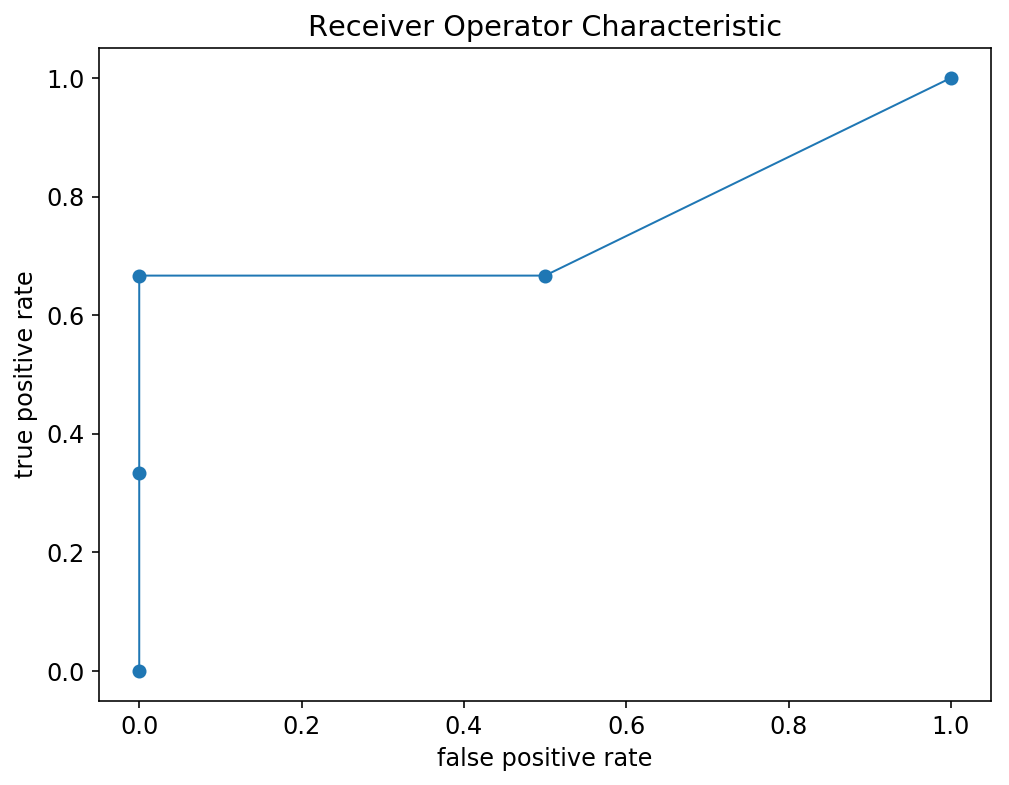

In [10]:
# convert count to rate, append 0 to
# both true positive and false positive
# so the visualization will start from origin (0, 0)
tpr = np.hstack((0, tps / tps[-1]))
fpr = np.hstack((0, fps / fps[-1]))
print('true positive rate:', tpr)
print('false positive rate:', fpr)

plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

fig = plt.figure()
plt.plot(fpr, tpr, marker = 'o', lw = 1)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.show()

Now to calculate the AUC (Area Under the Curve) for the ROC curve, we need sum up the rectangular area and the triangular area under the curve. Depicted by the visualization below:

- For the rectangular area (the plot on the left illustrates one of them), the height are the TPR (true positive rate) and widths are in the difference in the FPR (false positive rate), so the total area of all the rectangles is the dot product of TPR and FPR's differences
- For the triangluar area (the plot on the right illustrates one of them), the height are the difference in TPR (true positive rate) and widths are in the difference in the FPR (false positive rate), so the total area of all the rectangles is the dot product of both TPR's and FPR's difference. But only half the area of each rectangle is below its segment of the ROC curve, thus we divide the rectangle by 2 to obtain the triangular area

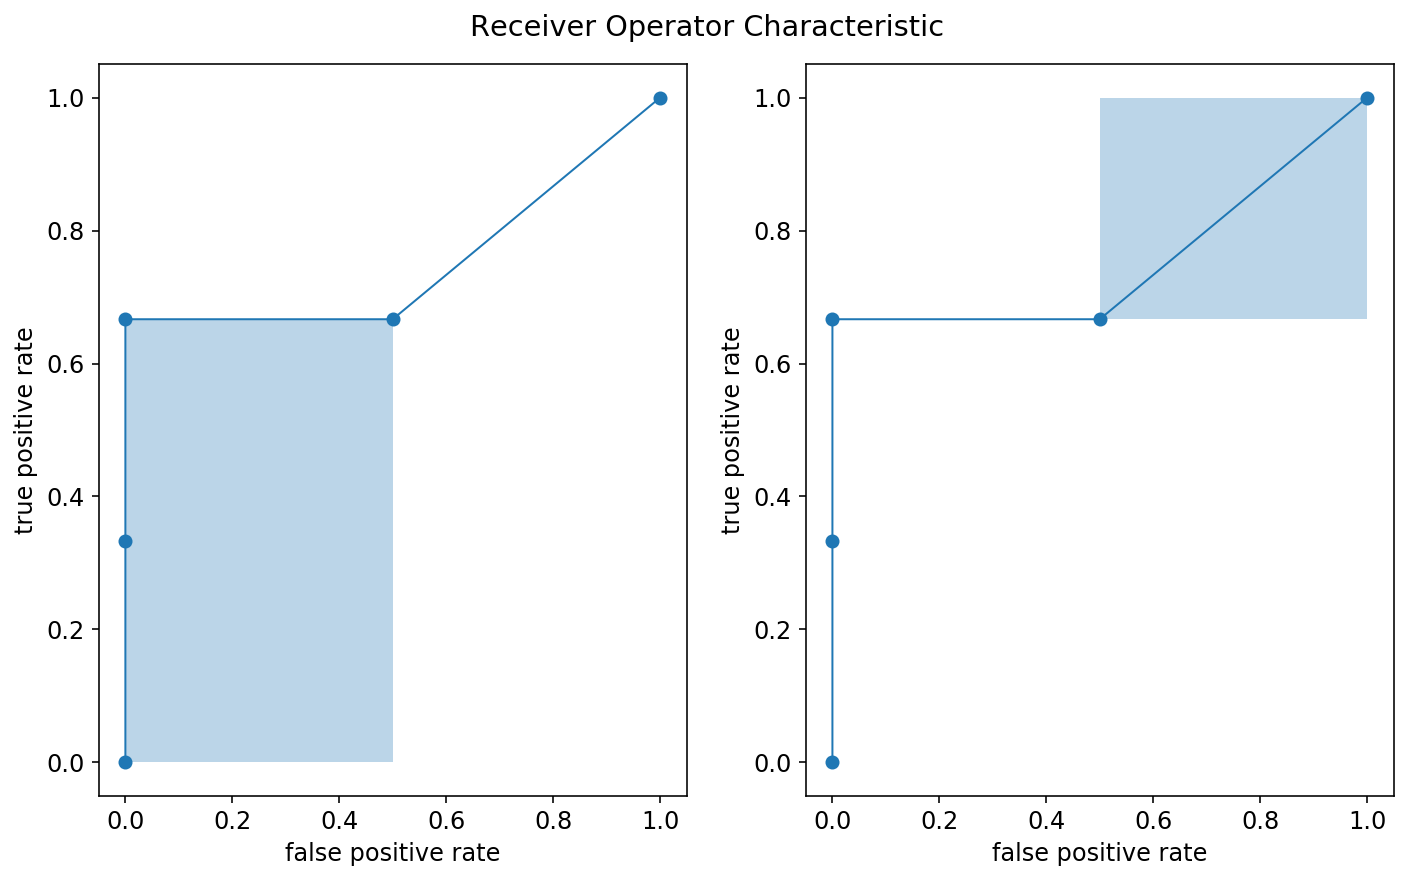

In [11]:
import matplotlib.patches as patches


fig, ax = plt.subplots(1, 2, figsize = (10, 6))
fig.suptitle('Receiver Operator Characteristic', y = 1.02)

# this part is hard-coded for illustration purpose
fpr_diff = fpr[3] - fpr[0]
tpr_diff = tpr[3] - tpr[0]
rect1 = patches.Rectangle(xy = (0, 0), width = fpr_diff,
                          height = tpr_diff, alpha = 0.3)
ax[0].add_patch(rect1)

fpr_diff = fpr[-1] - fpr[-2]
tpr_diff = tpr[-1] - tpr[-2]
rect2 = patches.Rectangle(xy = (fpr[-2], tpr[-2]), width = fpr_diff,
                          height = tpr_diff, alpha = 0.3)
ax[1].add_patch(rect2)

for i in range(len(ax)):
    ax[i].plot(fpr, tpr, marker = 'o', lw = 1)
    ax[i].set_xlabel('false positive rate')
    ax[i].set_ylabel('true positive rate')

plt.tight_layout()
plt.show()

In [12]:
def _roc_auc_score(y_true, y_score):
    """
    Compute Area Under the Curve (AUC) from prediction scores

    Parameters
    ----------
    y_true : 1d ndarray, shape = [n_samples]
        True targets/labels of binary classification

    y_score : 1d ndarray, shape = [n_samples]
        Estimated probabilities or scores

    Returns
    -------
    auc : float
    """

    # ensure the target is binary
    if np.unique(y_true).size != 2:
        raise ValueError('Only two class should be present in y_true. ROC AUC score '
                         'is not defined in that case.')
    
    tps, fps, _ = _binary_clf_curve(y_true, y_score)

    # convert count to rate
    tpr = tps / tps[-1]
    fpr = fps / fps[-1]

    # compute AUC using the trapezoidal rule;
    # appending an extra 0 is just to ensure the length matches
    zero = np.array([0])
    tpr_diff = np.hstack((np.diff(tpr), zero))
    fpr_diff = np.hstack((np.diff(fpr), zero))
    auc = np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2
    return auc

In [13]:
auc_score = _roc_auc_score(y_true, y_score)
print('auc score:', auc_score)

# confirm with scikit-learn's result
auc_score = roc_auc_score(y_true, y_score)
print('package auc socre:', auc_score)

auc score: 0.75
package auc socre: 0.75


After working through the implementation of ROC curve and AUC score from sratch, we now pull back and visualize:

- The ROC curve of our original model
- Dotted line represents the ROC curve of a purely random classifier and a perfect classifier

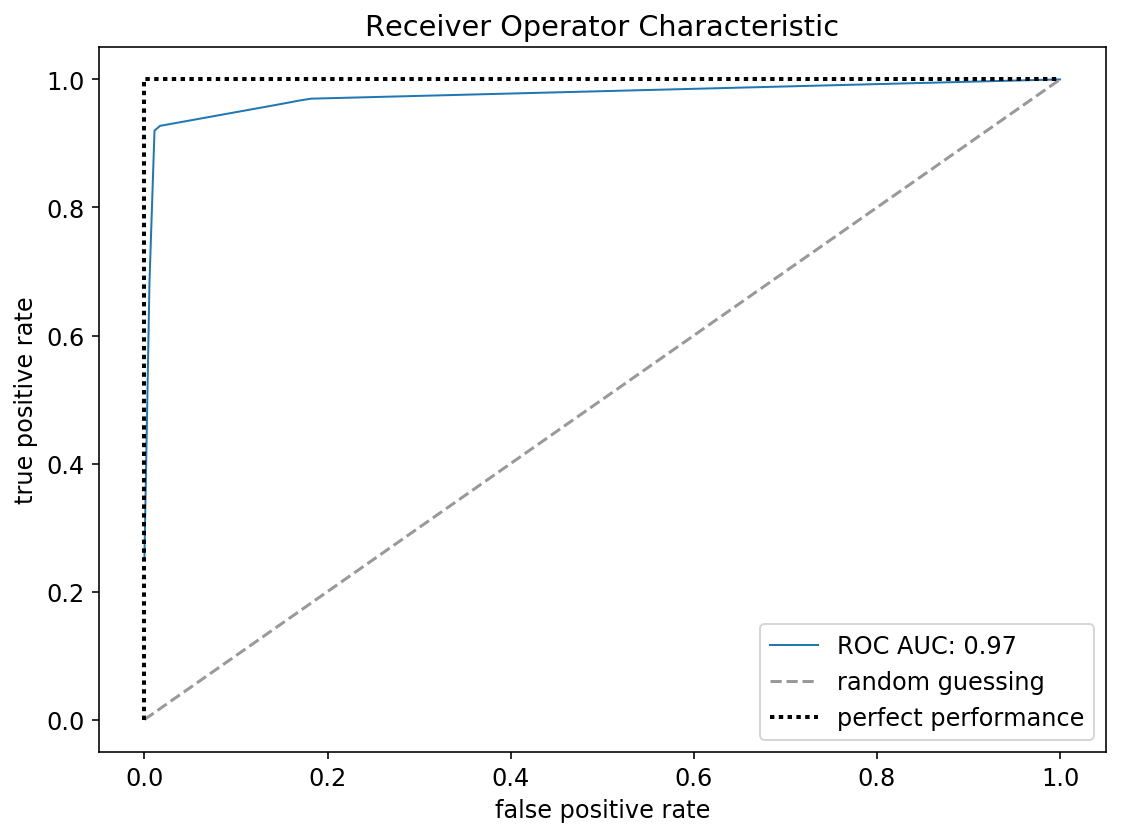

In [14]:
# calling the roc_curve, extract the probability of 
# the positive class from the predicted probability
tree_test_pred = tree.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, tree_test_pred, pos_label = 1)

# AUC score that summarizes the ROC curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw = 1, label = 'ROC AUC: {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':', lw = 2,
         color = 'black', 
         label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

The goal of visualizing the  ROC curve is to let us know how well can our classifier be expected to perform in general, at a variety of different baseline probabilities (percentage of the majority class)?

The diagnoal line depicts a completely random classifier and ideally our model's ROC curve should be toward the top-left corner and stay as far away from the diagnoal line as possible.

Side note: Apart from comparing the model's ROC curve against the ROC curve of a classifier that does random guessing, it's also useful to plot the ROC curve of different classifiers to compare performance against each other.


### AUC probabilistic interpretation


The probabilistic interpretation of the AUC metric is that if we randomly choose a positive case and a negative case, the probability that the positive case outranks the negative case according to the classifier is given by the AUC. Hopefully, this is evident from the ROC curve figure, where plot is enumerating all possible combinations of positive and negative cases, and the fraction under the curve comprises of the area where the positive case outranks the negative one. I personally find this interpretation extremely useful when conveying what AUC is measuring to a non-technical audience.



In [15]:
def auc_probability(y_true, y_score, size = 100000):
    """probabilistic interpretation of AUC"""
    labels = y_true.astype(np.bool)
    pos = np.random.choice(y_score[labels], size = size, replace = True)
    neg = np.random.choice(y_score[~labels], size = size, replace = True)
    auc = np.sum(pos > neg) + np.sum(pos == neg) / 2
    auc /= size
    return auc


# we want this be close the score returned
# by roc_auc_score
auc_probability(y_true = y_test, y_score = tree_test_pred)

0.97479499999999997

## Cost


While AUC gives a single-number summary of classifier performance that is suitable in some circumstances, other metrics are often more appropriate. For binary classifiers, evaluation metrics that take into account the actual costs of false positive and false negative errors may be much more appropriate than AUC. If we know these costs, we can use them not only to tie to more directly to the business value but also choose the final cutoff threhold for the classifier.

In real world application, the cost that comes along with making these two mistakes (false positive and false negative) are usually a whole lot different. Take our case for example, a false negative (FN) means an employee left our company but our model failed to detect that, while a false positive (FP) means an employee is still currently working at our company and our model told us that they will be leaving. The former mistake would be a tragedy, since, well, the employee left and we didn’t do anything about it! As for conducting the latter mistake, we might be wasting like 20 minutes of a HR manager's time when we arrange a face to face interview with a employee, questioning about how the company can do better to retain him, while he's perfectly fine with the current situation.

In [19]:
from sklearn.metrics import precision_recall_curve

test_size = 0.2
random_states = 1234, 123, 123456
num_cols = ['S', 'LPE', 'NP', 'ANH', 'TIC']
cat_cols = ['Newborn']

plot_data = []
for random_state in random_states:
    data_train, data_test, y_train, y_test = train_test_split(
        data, label, test_size = test_size, random_state = random_state, stratify = label)

    preprocess = Preprocess(num_cols, cat_cols)
    X_train = preprocess.fit_transform(data_train)
    X_test = preprocess.transform(data_test)

    tree = DecisionTreeClassifier(max_depth = 4)
    tree.fit(X_train, y_train)

    tree_test_pred = tree.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(
        y_test, tree_test_pred, pos_label = 1)

    thresholds = np.append(thresholds, 1)

    info = {'precision': precision, 'recall': recall, 'thresholds': thresholds}
    plot_data.append(info)

In [28]:
precisions = [p['precision'] for p in plot_data]
precisions

[array([ 0.16694491,  0.51527224,  0.5308642 ,  0.57313433,  0.91604938,
         0.94358974,  0.96126761,  1.        ,  1.        ]),
 array([ 0.1671542 ,  0.49675746,  0.51069519,  0.55886736,  0.88997555,
         0.89189189,  0.94255875,  0.94240838,  0.96603774,  1.        ,  1.        ]),
 array([ 0.16729402,  0.50260417,  0.51747312,  0.77254098,  0.90384615,
         0.93734336,  0.94206549,  0.97003745,  1.        ,  1.        ])]

In [31]:
precisions[0].shape

(9,)

In [33]:
precisions[2].shape

(10,)

In [30]:
quantiles = [0.1, 0.5, 0.9]
np.percentile(precisions, quantiles, axis = 0)

ValueError: operands could not be broadcast together with shapes (10,) (11,) 

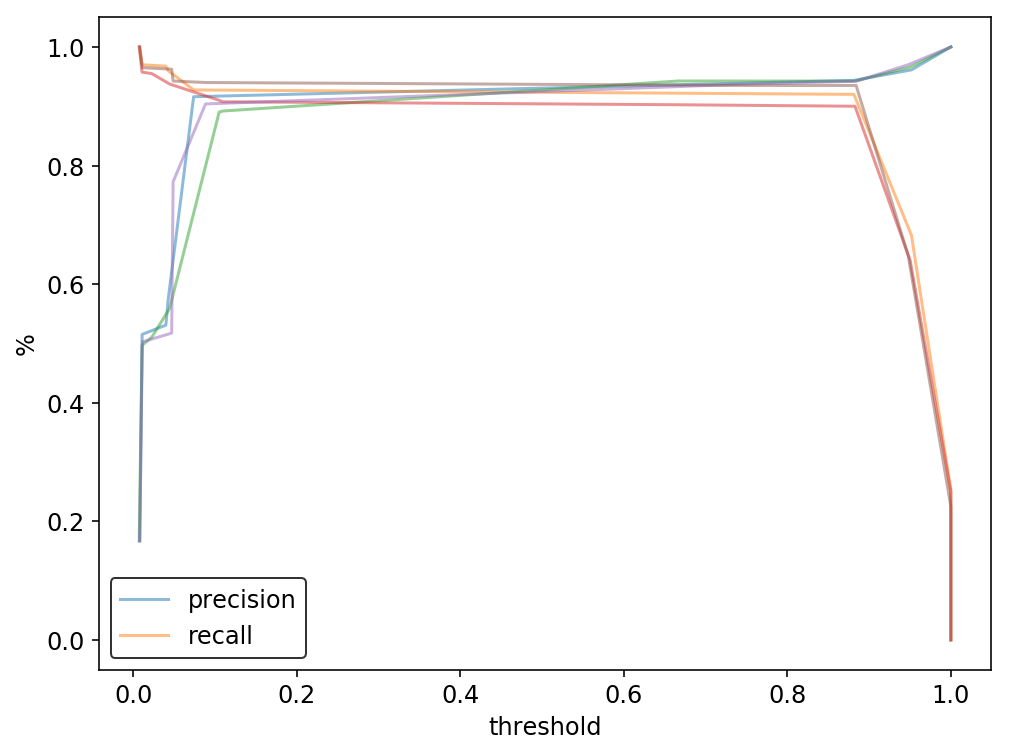

In [22]:
alpha = 0.5
for p in plot_data:
    plt.plot(p['thresholds'], p['precision'], alpha = alpha)
    plt.plot(p['thresholds'], p['recall'], alpha = alpha)

legend = plt.legend(('precision', 'recall'), frameon = True)
legend.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')
plt.show()

# Reference

- [Blog: Calculating AUC: the area under a ROC Curve](http://blog.revolutionanalytics.com/2016/11/calculating-auc.html)